In [1]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

In [2]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2 

In [3]:
suppressPackageStartupMessages(require(vars))
require(bigtime)
require(tidyverse)

Loading required package: bigtime

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ strucchange::boundary() masks stringr::boundary()
✖ dplyr::filter()         masks stats::filter()
✖ dplyr::lag()            masks stats::lag()
✖ MASS::select()          masks dplyr::select()



In [4]:
print("CORRESPONDANCE LABEL - NOMBRE SECTEURS")
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
lab.to.num

[1] "CORRESPONDANCE LABEL - NOMBRE SECTEURS"


lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


In [5]:
colnames(df.ts) <-lab.to.num$num
colnames(covid.ts) <- lab.to.num$num

 <hr>

 ## Dimension reduction

In [6]:
data(var.example)
Y.var

Y1,Y2,Y3,Y4,Y5
-0.013685419,-0.21562607,0.53368096,-0.41617206,1.04240414
0.709438600,0.23719800,1.03306134,-0.38787703,0.29187347
1.337836073,-0.07226727,1.24361313,-0.13930234,1.10318985
0.924948364,1.72047835,2.31593834,0.69942473,-0.08991051
0.332536164,1.19911551,1.15456457,-0.62745894,1.59638058
0.001163325,0.25942547,0.11754757,-0.59776471,-0.65383498
2.718902802,-0.13894789,-0.76932701,-1.77068287,-0.04697368
1.602044149,0.57587756,-0.75071287,0.25279833,0.66041914
1.847479478,0.93429531,-0.59042961,-0.28369693,0.23297671
0.779372980,-0.34099632,-1.68440336,-0.31612319,-0.60548041


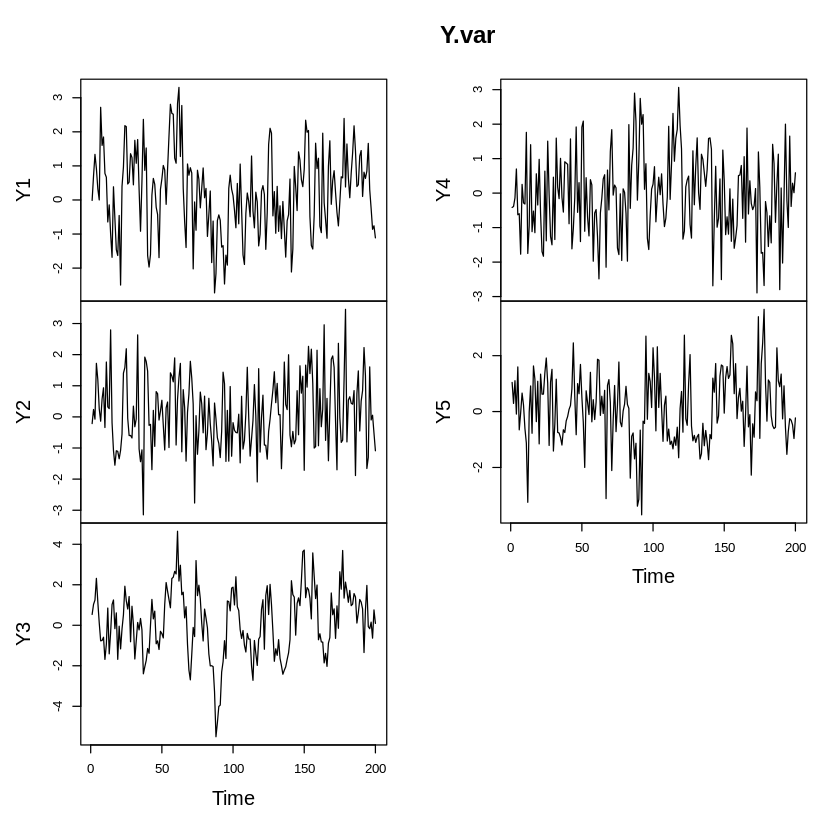

In [7]:
plot.ts(Y.var)

In [8]:
df <- as.data.frame(df.ts)

In [9]:
 df <-df %>% as.matrix()


In [10]:

colnames(df) <- paste("DF",1:dim(df)[2],sep="")

In [11]:
df

DF1,DF2,DF3,DF4,DF5,DF6,DF7,DF8,DF9,DF10,⋯,DF17,DF18,DF19,DF20,DF21,DF22,DF23,DF24,DF25,DF26
1290,355,70,156,1183,94,135,123,898,573,⋯,261,109,18,32,211,67,338,978,3087,49
1284,354,72,156,1192,92,136,124,897,570,⋯,263,112,19,30,212,69,341,1019,3154,50
1279,356,72,156,1147,92,148,126,902,572,⋯,299,109,19,32,205,71,346,996,3119,54
1278,347,72,156,1185,94,139,125,905,573,⋯,252,112,19,32,199,71,345,1023,3133,51
1276,393,71,155,1168,99,150,124,902,565,⋯,254,111,20,29,198,71,341,1002,3056,49
1274,394,71,153,1179,98,151,125,908,561,⋯,255,110,17,29,204,69,346,1035,3107,47
1269,392,72,157,1122,98,150,123,910,560,⋯,290,106,18,32,202,69,350,998,3094,50
1267,392,70,150,1162,96,150,124,913,556,⋯,246,112,16,32,202,73,340,1008,3094,52
1259,394,68,147,1169,96,152,125,910,549,⋯,242,108,15,32,199,75,335,995,3097,53
1257,393,68,147,1173,97,154,126,919,551,⋯,242,108,17,32,199,72,334,1036,3149,53


In [12]:
#-----------------------------
# Plot function 
#require(tidyverse)
plot_series <- function(Y){
  as_tibble(Y) %>%
  mutate(Time = 1:n()) %>%
  pivot_longer(-Time, names_to = "Series", values_to = "vals") %>%
  mutate(Series = factor(Series, levels = colnames(Y))) %>%
  ggplot() +
  geom_line(aes(Time, vals)) + 
  facet_wrap(facets = vars(Series), ncol = 1) + 
  ylab("") +
  theme_bw()
}

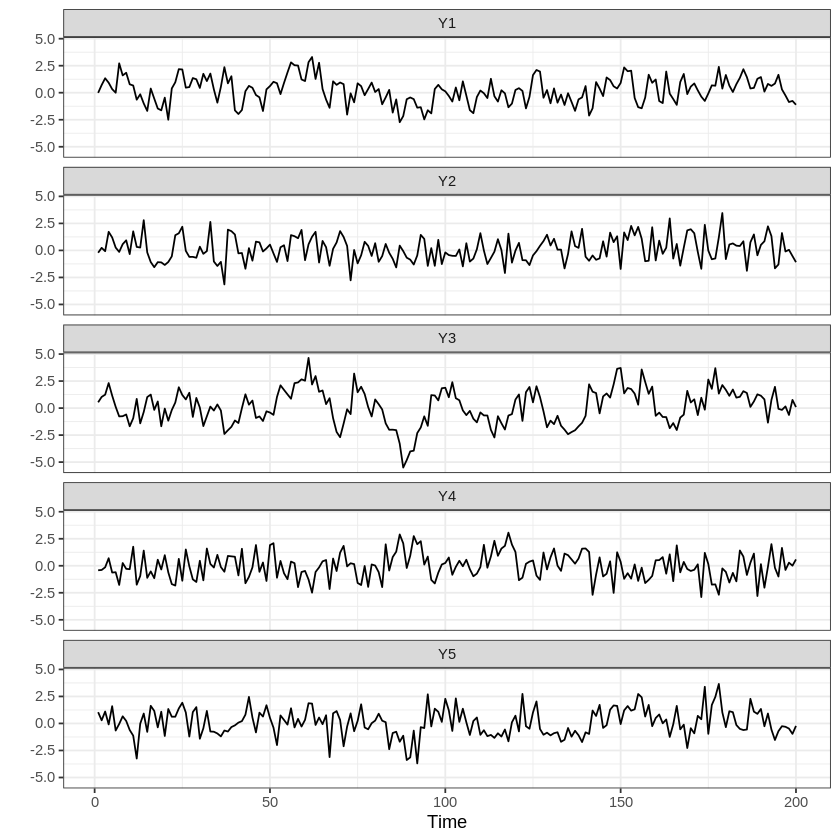

In [13]:
plot_series(Y.var)

# Lasso Estimation using L1 penalty on the autoregressive coefficients

In [14]:
VAR.L1.1 <-sparseVAR(
    Y=scale(df),
    VARpen="L1",
)

In [15]:
VAR.L1.2 <- sparseVAR(Y=scale(df),  # standardising the data
                   selection = "cv", # using time series cross-validation
                   VARpen = "L1") # using the lasso penalty

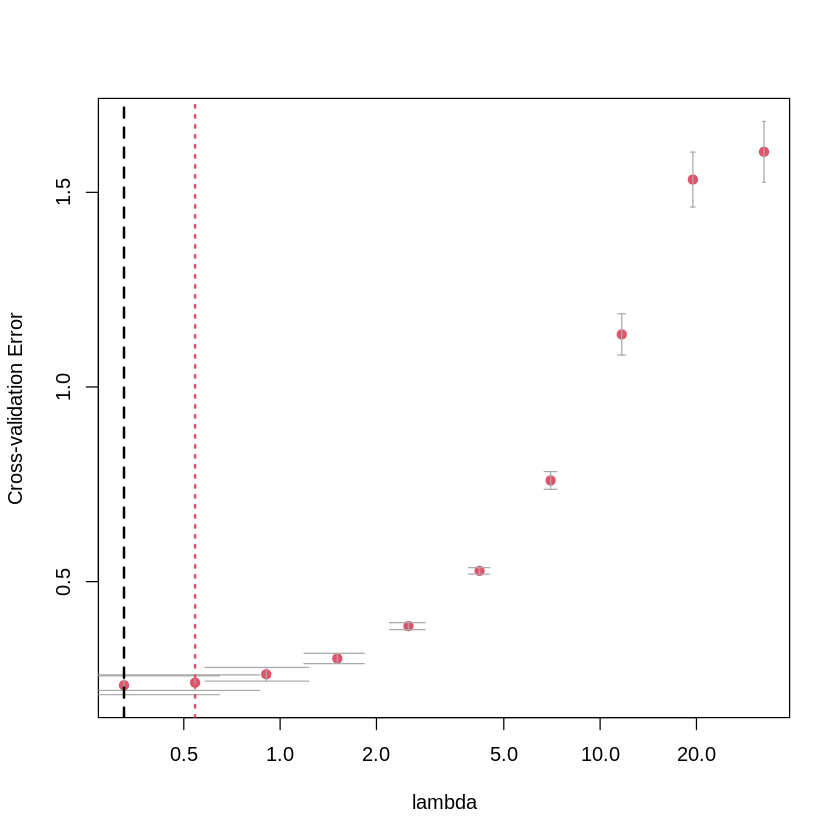

In [16]:
plot_cv(VAR.L1.2)

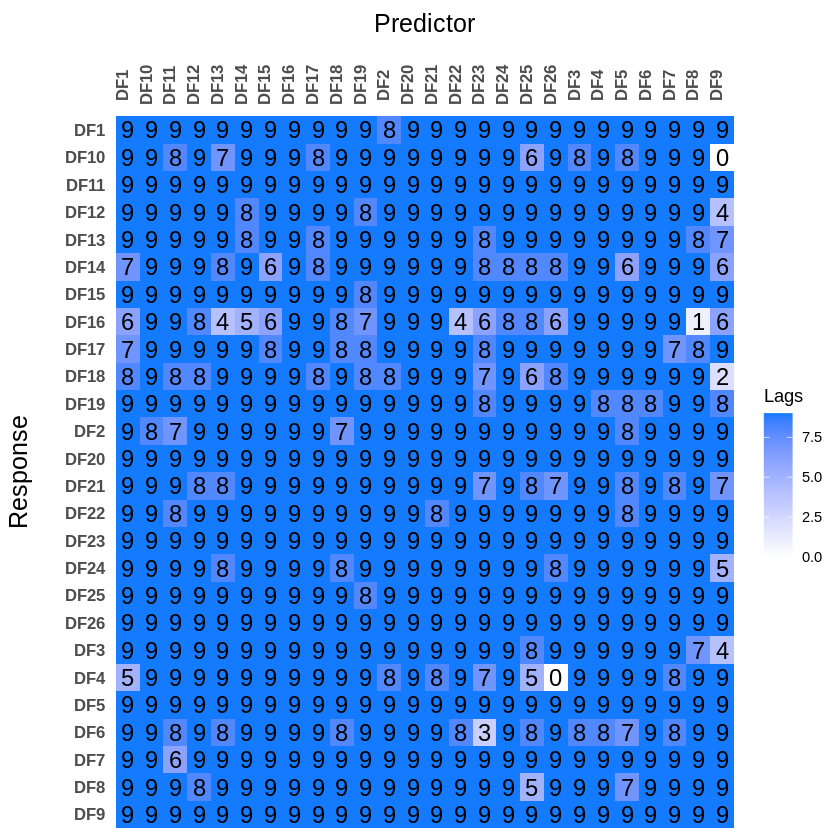

In [17]:
LhatL1 <- lagmatrix(fit=VAR.L1.2, returnplot=TRUE)

In [18]:
attributes(VAR.L1.2)

$names
 [1] "k"            "Y"            "p"            "Phihat"       "phi0hat"     
 [6] "series_names" "lambdas"      "MSFEcv"       "MSFE_all"     "lambda_SEopt"
[11] "lambda_opt"   "h"            "selection"   

$class
[1] "bigtime.VAR"

In [19]:
summary(VAR.L1.2)

             Length Class  Mode     
k               1   -none- numeric  
Y            1040   -none- numeric  
p               1   -none- numeric  
Phihat       6084   -none- numeric  
phi0hat        26   -none- numeric  
series_names   26   -none- character
lambdas        10   -none- numeric  
MSFEcv         10   -none- numeric  
MSFE_all       40   -none- numeric  
lambda_SEopt    1   -none- numeric  
lambda_opt      1   -none- numeric  
h               1   -none- numeric  
selection       1   -none- character

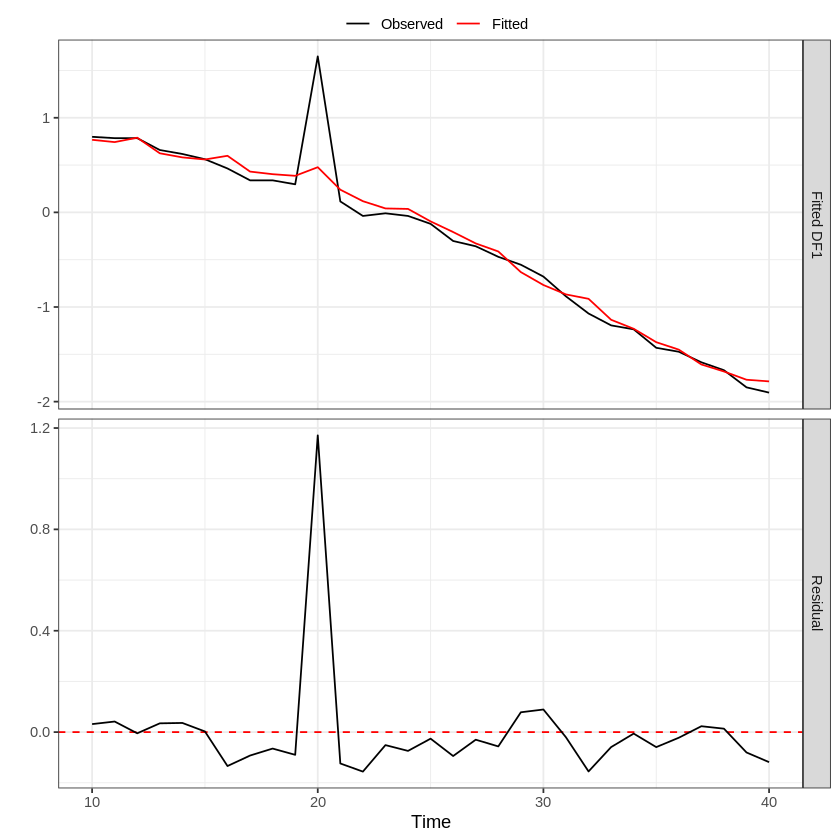

In [20]:
#p_bic <- diagnostics_plot(VAR.L1.1, variable = "DF1") # variable argument can be numeric or character
p_cv <- diagnostics_plot(VAR.L1.2, variable = "DF1") # variable argument can be numeric or character

plot(p_cv)

In [21]:
VAR.forecast <-directforecast(VAR.L1.2)


In [22]:
is.stable(VAR.L1.2)


[1] TRUE

In [23]:
VAR.forecast

[1] -1.8869746 -0.4781195  1.3377363 -0.6486923 -1.8626813 -0.2199039
 [7]  1.6659462  1.4745688  1.7777275 -0.5046111  1.5597497 -1.6970402
[13] -2.1082457 -0.5019769 -0.6951611 -0.4109655 -0.5710437 -0.2368404
[19] -1.3839204 -0.4696720 -1.5732419 -1.1570271 -1.9933196 -0.9180313
[25] -2.3443185  2.1434272

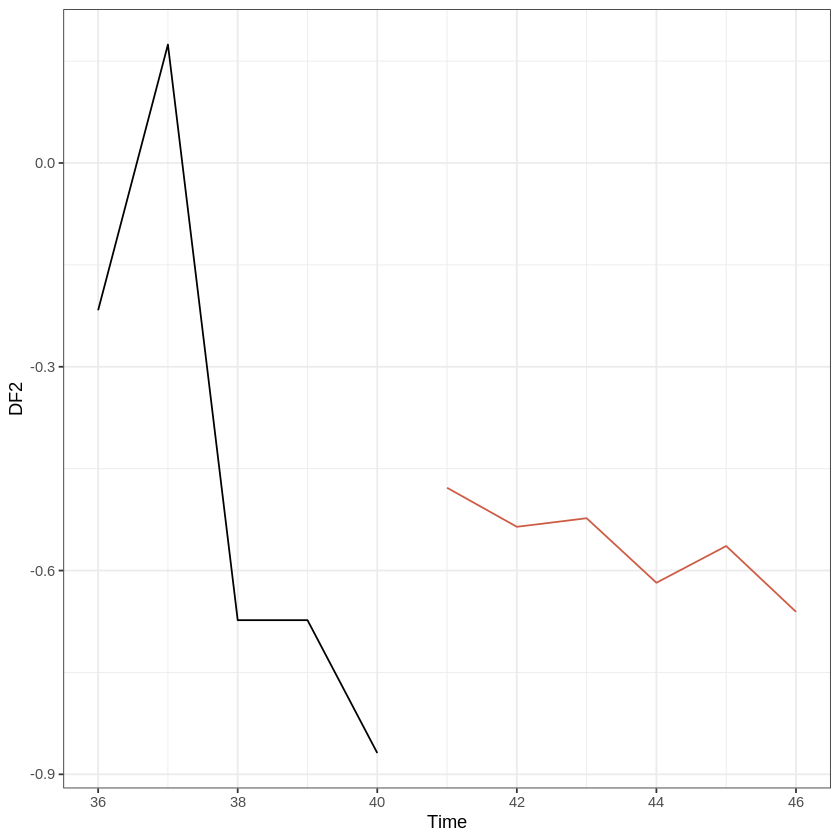

In [24]:
VAR.forecast.bis <- recursiveforecast(VAR.L1.2,h=6)
plot(VAR.forecast.bis,series="DF2")

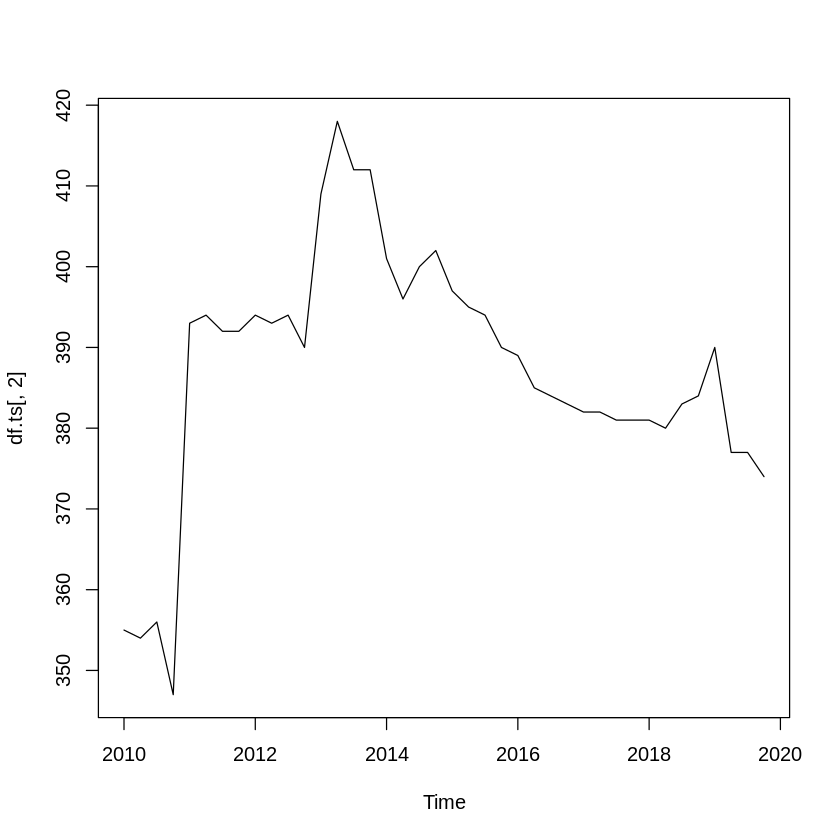

In [25]:
plot.ts(df.ts[,2])

= > diff_inv or unsceld the series + the prediction 

In [26]:
df[,2]

[1] 355 354 356 347 393 394 392 392 394 393 394 390 409 418 412 412 401 396 400
[20] 402 397 395 394 390 389 385 384 383 382 382 381 381 381 380 383 384 390 377
[39] 377 374

In [28]:

df.scaled <- scale(df)
centered_scale <-attr(df.scaled,"scaled:center")[2]
sd_scale <-attr(df.scaled,"scaled:scale")[2]


In [33]:
pred <-VAR.forecast.bis$fcst[,2]

final <-pred*sd_scale + centered_scale


In [31]:
centered_scale
sd_scale

DF2 
387.325

DF2 
15.34123

In [37]:
print("---------PRED")
pred
print("---------centerd_scale")
c <-rep(centered_scale[[1]],length(pred))
scale <-rep(sd_scale[[1]],length(pred))
print("-----apply")
pred <-pred*scale +c

[1] "---------PRED"


[1] -0.4781195 -0.5355788 -0.5229495 -0.6179230 -0.5638962 -0.6607077

[1] "---------centerd_scale"
[1] "-----apply"


In [41]:
obs <-covid.ts %>%as.data.frame
obs <- obs[,2]

In [42]:
obs

[1] 370 358 357 353 347 346

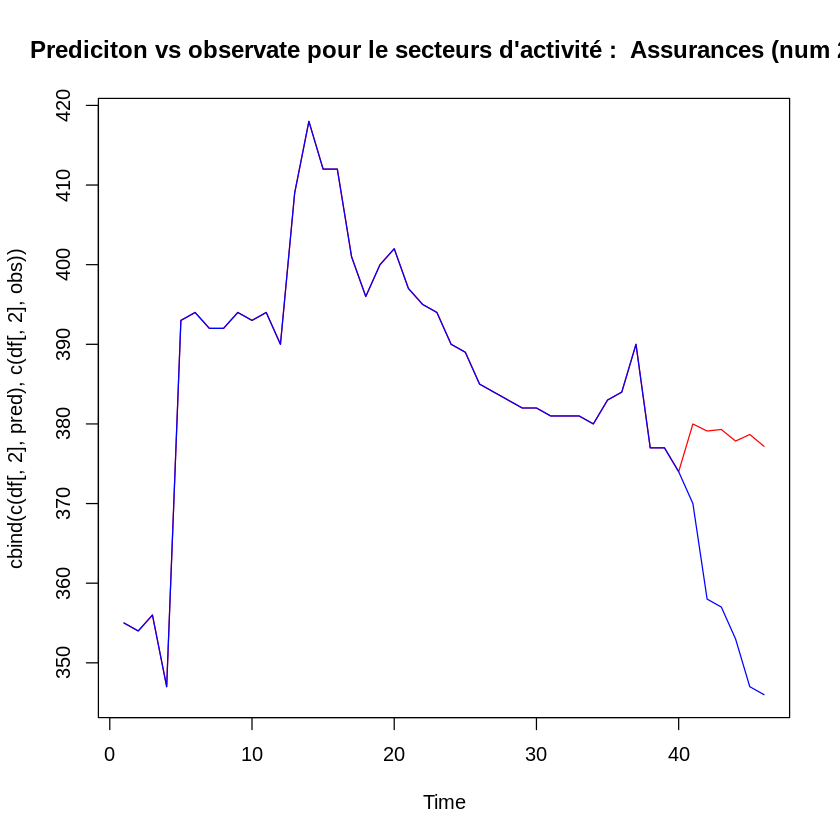

In [45]:
plot.ts(
    cbind(c(df[,2],pred),c(df[,2],obs)),plot.type="single",col=c("red","blue"),
    main="Prediciton vs observate pour le secteurs d'activité :  Assurances (num 2)"
)

 Big time github: https://github.com/ineswilms/bigtime